# Week 9

This week, we will cover two new ideas:

* The last of the relatively novel CNNs, the ResNet (He et al. 2015, https://arxiv.org/abs/1512.03385), which allows for deeper networks without gradients vanishing by implementing "skip-connections" that pass data forward in networks, skipping certain layers.

* Ensemble learning -- the idea that we can train several *different* neural networks on a dataset and let them *vote* on inferences.

# ResNet

Let's implement a ResNet here. We will write a function to create residual modules first and then iteratively construct the architecture to save some repetition.

In [1]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import add
from tensorflow.keras import backend

In [4]:
class ResNet:
    def residual_module(data, K, stride, channelsDim, reduce = False, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9):
        shortcut = data
        
        # 1x1 CONVs
        bn1 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(data)
        act1 = Activation('relu')(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act1)
        
        # 3x3 CONVs
        bn2 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv1)
        act2 = Activation('relu')(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides = stride, padding = 'same', use_bias = False, kernel_regularizer = l2(reg))(act2)
        
        # 1x1 CONVs
        bn3 = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(conv2)
        act3 = Activation('relu')(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias = False, kernel_regularizer = l2(reg))(act3)
        
        # if we reduce the spatial size, apply a CONV layer to the shortcut
        if reduce:
            shortcut = Conv2D(K, (1, 1), strides = stride, use_bias = False, kernel_regularizer = l2(reg))(act1)
            
        # add the shortcut and the final CONV
        x = add([conv3, shortcut])
        
        return x
    
    def build(width, height, depth, classes, stages, filters, reg = 0.0001, bnEpsilon = 0.00002, bnMomentum = 0.9, dataset='cifar'):
        inputShape = (height, width, depth)
        channelsDim = -1
        
        if backend.image_data_format() == 'channels_first':
            inputShape = (depth, height, width)
            channelsDim = 1
            
        # set the input and apply BN
        inputs = Input(shape = inputShape)
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(inputs)
        
        if dataset == 'cifar':
            # apply a single CONV layer
            x = Conv2D(filters[0], (3, 3), use_bias = False, padding = 'same',
                       kernel_regularizer = l2(reg))(x)
        
        # loop over the number of stages
        for counter in range(0, len(stages)):
            # initialize the stride
            if counter == 0:
                stride = (1, 1)
            else:
                stride = (2, 2)
                    
            # apply a residual module to reduce the spatial dimension of the image volume
            x = ResNet.residual_module(x, filters[counter + 1], stride, channelsDim, reduce = True, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
            
            # loop over the number of layers in the current stage
            for j in range(0, stages[counter] - 1):
                # apply a residual module
                x = ResNet.residual_module(x, filters[counter + 1], (1, 1), channelsDim, bnEpsilon = bnEpsilon, bnMomentum = bnMomentum)
                    
        # apply BN -> ACT -> POOL
        x = BatchNormalization(axis = channelsDim, epsilon = bnEpsilon, momentum = bnMomentum)(x)
        x = Activation('relu')(x)
        x = AveragePooling2D((8, 8))(x)
        
        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer = l2(reg))(x)
        x = Activation('softmax')(x)
        
        # create the model
        model = Model(inputs, x, name = 'ResNet')
        
        # return the model
        return model

### ResNet on CIFAR-10

Let's test it on CIFAR-10, this time with data augmentation from the start.

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
Model: "ResNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 3)    12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   1728        batch_normalization[0][0]        
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 64)   256         conv2d[0][0]                     
___________________________________

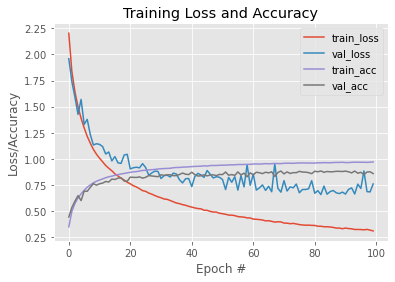

In [4]:
# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode="nearest")

print("[INFO] compiling model...")
opt = SGD(lr = 0.1)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

# print a model summary
print(model.summary())

print("[INFO] training network...")
H = model.fit(aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 128, epochs=100, verbose=1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

### ResNet Experiment 2: Data Augmentation and a Learning Rate Scheduler

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
[INFO] training network...
  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/100
390/390 [==============================] - 62s 160ms/step - loss: 2.2054 - accuracy: 0.3525 - val_loss: 1.9545 - val_accuracy: 0.4573
Epoch 2/100
390/390 [==============================] - 50s 129ms/step - loss: 1.8504 - accuracy: 0.4976 - val_loss: 1.7733 - val_accuracy: 0.5244
Epoch 3/100
390/390 [==============================] - 50s 129ms/step - loss: 1.6691 - accuracy: 0.5634 - val_loss: 1.6154 - val_accuracy: 0.5886
Epoch 4/100
390/390 [==============================] - 51s 130ms/step - loss: 1.5205 - accuracy: 0.6220 - val_loss: 1.5732 - val_accuracy: 0.6077
Epoch 5/100
390/390 [==============================] - 51s 130ms/step - loss: 1.4065 - accuracy: 0.6630 - val_loss: 1.5530 - val_accuracy: 0.6298
Epoch 6/100
390/390 [==============================] - 51s 130ms/step - loss: 1.3090 - accuracy: 0.6994 - val_los

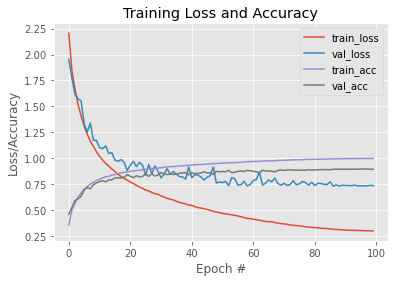

In [6]:
numberOfEpochs = 100
initialLearningRate = 0.1

# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode="nearest")

print("[INFO] compiling model...")
opt = SGD(lr = initialLearningRate)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

# print a model summary
#print(model.summary())

print("[INFO] training network...")

# code for a learning rate scheduler
def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha

callbacks = [LearningRateScheduler(polynomial_decay)]

H = model.fit(aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 128, epochs=numberOfEpochs, callbacks = callbacks, verbose=1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

[INFO] loading CIFAR-10 data...
[INFO] compiling model...
[INFO] training network...
  ...
    to  
  ['...']
Train for 390 steps, validate on 10000 samples
Epoch 1/100
390/390 [==============================] - 70s 180ms/step - loss: 2.1935 - accuracy: 0.3567 - val_loss: 2.0183 - val_accuracy: 0.4486
Epoch 2/100
390/390 [==============================] - 58s 149ms/step - loss: 1.8222 - accuracy: 0.5068 - val_loss: 1.8062 - val_accuracy: 0.5114
Epoch 3/100
390/390 [==============================] - 58s 148ms/step - loss: 1.6449 - accuracy: 0.5750 - val_loss: 1.8068 - val_accuracy: 0.5268
Epoch 4/100
390/390 [==============================] - 60s 153ms/step - loss: 1.5023 - accuracy: 0.6272 - val_loss: 1.4579 - val_accuracy: 0.6419
Epoch 5/100
390/390 [==============================] - 60s 154ms/step - loss: 1.3948 - accuracy: 0.6677 - val_loss: 1.4275 - val_accuracy: 0.6598
Epoch 6/100
390/390 [==============================] - 61s 158ms/step - loss: 1.3090 - accuracy: 0.6975 - val_los

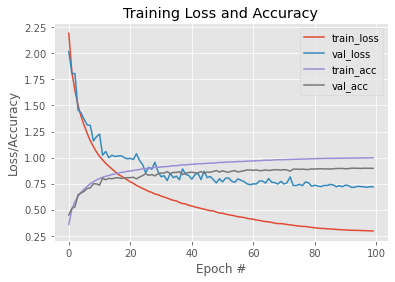

In [5]:
numberOfEpochs = 100
initialLearningRate = 0.1

# load the training and testing data
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float")
testX = testX.astype("float")

# apply mean subtraction to the data
mean = np.mean(trainX, axis=0)
trainX -= mean
testX -= mean

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

aug = ImageDataGenerator(width_shift_range = 0.1, height_shift_range = 0.1, horizontal_flip = True, fill_mode="nearest")

print("[INFO] compiling model...")
opt = SGD(lr = initialLearningRate)
model = ResNet.build(32, 32, 3, 10, (9, 9, 9), (64, 64, 128, 256), reg=0.0005)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

# print a model summary
#print(model.summary())

print("[INFO] training network...")

# code for a learning rate scheduler
def polynomial_decay(epoch):
    maxEpochs = numberOfEpochs
    baseLearningRate = initialLearningRate
    power = 1.0
    
    alpha = baseLearningRate * (1 - (epoch / float(numberOfEpochs))) ** power
    
    # return the learning rate
    return alpha

callbacks = [LearningRateScheduler(polynomial_decay)]

H = model.fit(aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY),
              steps_per_epoch=len(trainX) // 128, epochs=numberOfEpochs, callbacks = callbacks, verbose=1)

# print a classification report
print('\n Test accuracy')
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY, digits=4))

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, numberOfEpochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, numberOfEpochs), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, numberOfEpochs), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()

Results are good but a little underwhelming here--according to Identity Mappings in Deep Residual Networks (He et. al., 2016, https://arxiv.org/abs/1603.05027), a similar approach can reach about 94% accuracy.